### Q3: Install DBT using Miniconda ###

In [1]:
#show dbt is installed
!which dbt

/home/alexvlasik/miniconda3/envs/p4-env/bin/dbt


 ### Q9: Use dbt to transform the column names to single word or two-word names with "_" separator and create a view named transform_survey. ###

In [1]:
!grep -v password ~/.dbt/profiles.yml

p4_survey_pipeline:
  target: dev # by default
  outputs:
    dev:
      type: snowflake
      account: QK52109.us-central1.gcp
      user: AVLASIK
      role: P4_ROLE
      database: SURVEY_DATABASE 
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 10

    other_db:
      type: snowflake
      account: QK52109.us-central1.gcp
      user: AVLASIK
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 10


In [39]:
!cat p4_survey_pipeline/models/schema.yml

version: 2

sources:
  - name: survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey 
  - name: stock_by_day
    database: STOCK_TRACKING_US_STOCK_PRICES_BY_DAY
    schema: STOCK
    tables:
      - name: US_STOCK_METRICS
  - name: fx_by_day
    database: FOREX_TRACKING_CURRENCY_EXCHANGE_RATES_BY_DAY
    schema: STOCK
    tables:
      - name: FOREX_METRICS
  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE

In [11]:
!cat p4_survey_pipeline/models/staging/transform_survey.sql

with raw_survey as (
    select * from {{ source('survey_data', 'survey') }}
),

survey_transformed as (
    select
        {{ adapter.quote('EMAIL_ADDRESS') }} as email,
        {{ adapter.quote('WHAT_IS_YOUR_AGE_') }} as age,
        {{ adapter.quote('WHICH_BEST_DESCRIBES_YOUR_PRIMARY_MAJOR_OR_FIELD_OF_STUDY_IF_YOU_HAVE_MORE_THAN_ONE_MAJOR_PLEASE_SPECIFY_OTHER_MAJORS_AS_PART_OF_THE_NEXT_QUESTION_') }} as primary_major,
        {{ adapter.quote('IF_YOU_HAVE_SECONDARY_MAJORS_PLEASE_LIST_THEM_HERE_SEPARATED_BY_A_COMMA_') }} as secondary_major,
        {{ adapter.quote('ARE_YOU_A_RUNNER_CONSIDER_BOTH_RUNNING_ON_TREADMILL_AND_OUTDOORS_') }} as running,
        {{ adapter.quote('DO_YOU_CONSIDER_YOURSELF_A_PROCRASTINATOR_') }} as procrastination,
        {{ adapter.quote('HAVE_YOU_EVER_IN_YOUR_LIFE_HAD_A_PET_') }} as pet,
        {{ adapter.quote('IF_YOU_HAD_AN_EXTRA_HOUR_IN_YOUR_DAY_HOW_WOULD_YOU_SPEND_IT_') }} as extra_hour,
        {{ adapter.quote('WHAT_FACTOR_INFLUENCES_YOUR_COURSE_SEL

# Q10-Q16

In [7]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

In [42]:
with open("snowflake_password", "r") as file:
    snowflake_password = file.read()
    snowflake_password = snowflake_password.strip()
    
conn = snowflake.connector.connect(
    user = 'AVLASIK',
    password = snowflake_password,
    account = 'QK52109.us-central1.gcp'
)
cursor = conn.cursor()
cursor.execute("USE DATABASE SURVEY_DATABASE")
cursor.execute("USE SCHEMA SURVEY_SCHEMA")

### Q10: What is the favorite pizza topping of each class?

In [ ]:
df = pd.read_sql("""
                 
with toppings_ranked as (
  select STANDING, PIZZA_TOPPING, count(PIZZA_TOPPING) as topping_count,
    ROW_NUMBER() over (PARTITION BY STANDING order by COUNT(PIZZA_TOPPING) DESC) as rank
  from SURVEY_schema.transform_survey
  group by STANDING, PIZZA_TOPPING
)
        
select STANDING, PIZZA_TOPPING
from toppings_ranked
where rank = 1     
""", conn)
df

/tmp/ipykernel_2176430/481046265.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,STANDING,PIZZA_TOPPING
0,Grad,Other
1,Sophomore,pepperoni
2,Junior,pepperoni
3,Senior,pepperoni


### Q11: How many people in each class are night owls and early birds?

In [124]:
df = pd.read_sql("""

select STANDING, EARLYBIRD_NIGHTOWL, count(*) as count
from SURVEY_schema.transform_survey
where EARLYBIRD_NIGHTOWL != 'no preference'
group by STANDING, EARLYBIRD_NIGHTOWL
order by STANDING DESC
""", conn)
df

/tmp/ipykernel_2176430/2804206304.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,STANDING,EARLYBIRD_NIGHTOWL,COUNT
0,Sophomore,night owl,15
1,Sophomore,early bird,5
2,Senior,night owl,40
3,Senior,early bird,14
4,Junior,night owl,38
5,Junior,early bird,7
6,Grad,night owl,8
7,Grad,early bird,7


### Q12: Create a piechart breaking down pizza toppings.

/tmp/ipykernel_2181426/1533130511.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


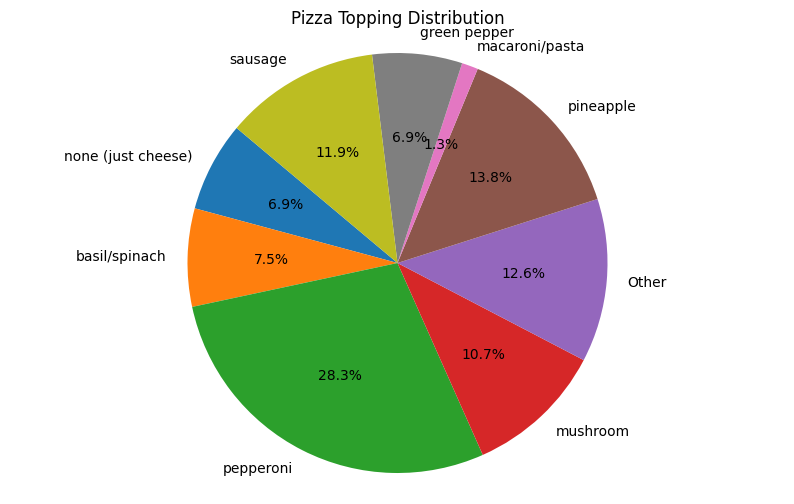

In [43]:
df = pd.read_sql("""
select PIZZA_TOPPING, count(*) as count
from SURVEY_schema.transform_survey
group by PIZZA_TOPPING
""", conn)

plt.figure(figsize=(10, 6))
plt.pie(df['COUNT'], labels=df['PIZZA_TOPPING'], startangle=140, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Pizza Topping Distribution')
plt.show()

### Q13: How are secondary majors distrubuted by students' primary majors?

/tmp/ipykernel_2176430/2073012315.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


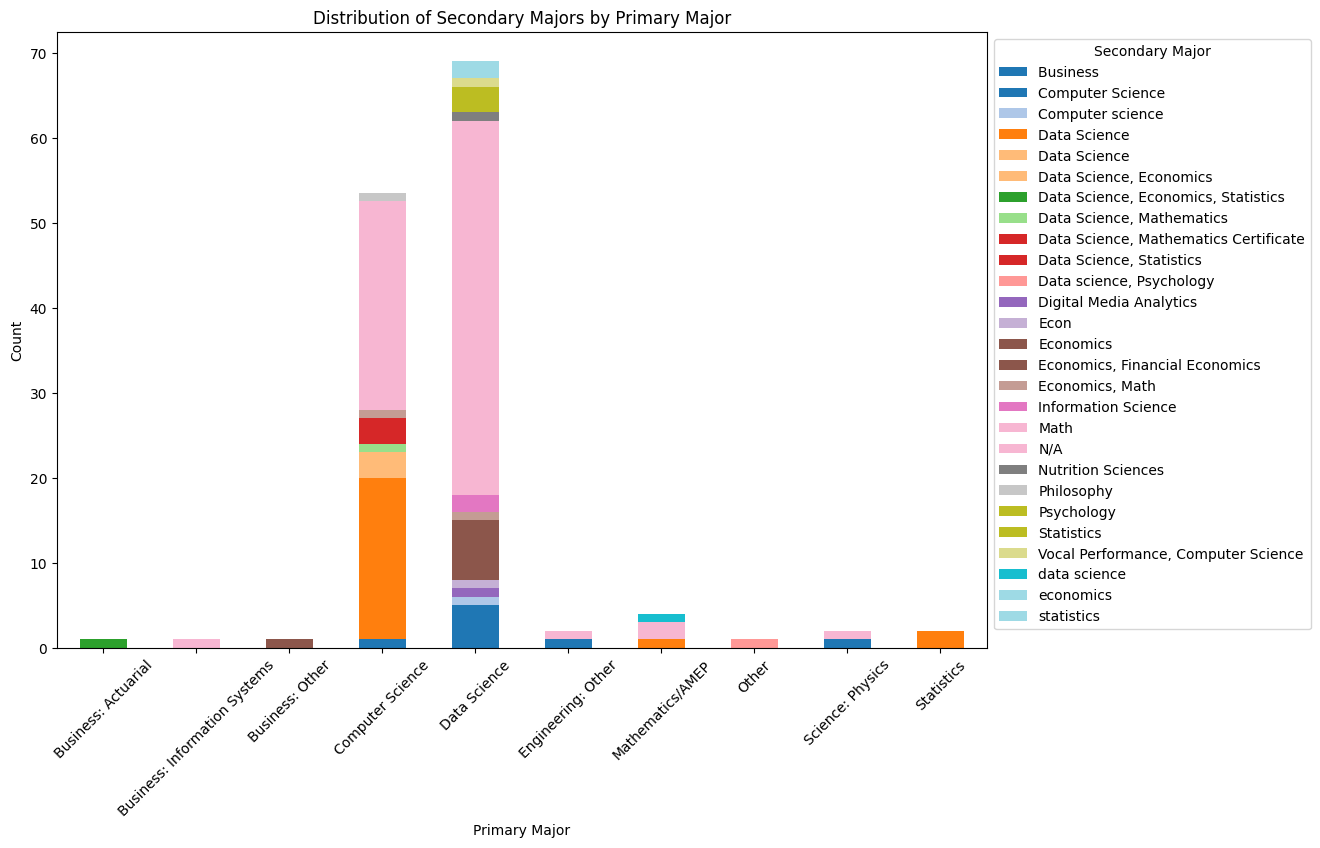

In [102]:
df = pd.read_sql("""
select PRIMARY_MAJOR, SECONDARY_MAJOR, count(*) as count
from SURVEY_schema.transform_survey
group by PRIMARY_MAJOR, SECONDARY_MAJOR
""", conn)

df['SECONDARY_MAJOR'] = df['SECONDARY_MAJOR'].fillna('N/A')
df = df.pivot_table(index='PRIMARY_MAJOR', columns='SECONDARY_MAJOR', values='COUNT')

df.plot(kind='bar', stacked=True, figsize=(12,8), colormap='tab20') # colormap required or else duplicate colors
plt.title('Distribution of Secondary Majors by Primary Major')
plt.xlabel('Primary Major')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Secondary Major', bbox_to_anchor=(1, 1))
plt.show()

### Q14: How does sleep preference differ between primary majors?

In [107]:
df = pd.read_sql("""
select PRIMARY_MAJOR,EARLYBIRD_NIGHTOWL, count(*) as count
from SURVEY_schema.transform_survey
group by PRIMARY_MAJOR, EARLYBIRD_NIGHTOWL
order by PRIMARY_MAJOR
""", conn)
df

/tmp/ipykernel_2176430/2227040216.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,PRIMARY_MAJOR,EARLYBIRD_NIGHTOWL,COUNT
0,Business: Actuarial,early bird,1
1,Business: Information Systems,night owl,1
2,Business: Other,early bird,1
3,Computer Science,night owl,51
4,Computer Science,no preference,12
5,Computer Science,early bird,13
6,Data Science,no preference,13
7,Data Science,night owl,39
8,Data Science,early bird,17
9,Engineering: Other,night owl,2


### Q15: How many procrastinators are there per class?

In [134]:
df = pd.read_sql("""
select STANDING, count(*) as count
from SURVEY_schema.transform_survey
where PROCRASTINATION = 'Yes'
group by STANDING
""", conn)
df

/tmp/ipykernel_2176430/1389367650.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,STANDING,COUNT
0,Sophomore,15
1,Senior,34
2,Junior,30
3,Grad,11


### Q16: What are the top 5 zipcodes that students reside in?

In [121]:
df = pd.read_sql("""
select ZIPCODE, count(*) as resident_count
from  SURVEY_schema.transform_survey
where ZIPCODE is not null
group by ZIPCODE
order by resident_count DESC
limit 5
                 
""", conn)
df

/tmp/ipykernel_2176430/2225775496.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,ZIPCODE,RESIDENT_COUNT
0,53703,68
1,53715,48
2,53706,11
3,53705,8
4,53711,7


### Q18: Configure ~/.dbt/profiles.yml for STOCK_DB

In [18]:
!grep -v password ~/.dbt/profiles.yml

p4_survey_pipeline:
  target: dev # by default
  outputs:
    dev:
      type: snowflake
      account: QK52109.us-central1.gcp
      user: AVLASIK
      role: P4_ROLE
      database: SURVEY_DATABASE 
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 10

    other_db:
      type: snowflake
      account: QK52109.us-central1.gcp
      user: AVLASIK
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 10


### Q19: Update models/schema.yml file to include new sources for STOCK_DB tables 

In [20]:
!cat p4_survey_pipeline/models/schema.yml

version: 2

sources:
  - name: survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey 
  - name: stock_by_day
    database: STOCK_TRACKING_US_STOCK_PRICES_BY_DAY
    schema: STOCK
    tables:
      - name: US_STOCK_METRICS
  - name: fx_by_day
    database: FOREX_TRACKING_CURRENCY_EXCHANGE_RATES_BY_DAY
    schema: STOCK
    tables:
      - name: FOREX_METRICS
  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE

### Q20: Create dbt_project.yml file in your dbt project directory --- p4_data_pipeline

In [21]:
!cat p4_survey_pipeline/dbt_project.yml


# Name your project! Project names should contain only lowercase characters
# and underscores. A good package name should reflect your organization's
# name or the intended use of these models
name: 'p4_survey_pipeline'
version: '1.0.0'

# This setting configures which "profile" dbt uses for this project.
profile: 'p4_survey_pipeline'

# These configurations specify where dbt should look for different types of files.
# The `model-paths` config, for example, states that models in this project can be
# found in the "models/" directory. You probably won't need to change these!
model-paths: ["models"]
analysis-paths: ["analyses"]
test-paths: ["tests"]
seed-paths: ["seeds"]
macro-paths: ["macros"]
snapshot-paths: ["snapshots"]

clean-targets:         # directories to be removed by `dbt clean`
  - "target"
  - "dbt_packages"


# Configuring models
# Full documentation: https://docs.getdbt.com/docs/configuring-models

# In this example config, we tell dbt to build all models in the example/


### Q21: Creating staging tables for FX and Stock

In [ ]:
!cat p4_survey_pipeline/models/staging/staging_valid_stock_tickers.sql

with raw_trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
)

select distinct TICKER, TRADE_DATE
from raw_trading_books
where DESK = 'Equity Desk'

In [3]:
!cat p4_survey_pipeline/models/staging/staging_valid_fx_tickers.sql

with raw_trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
)

select distinct TICKER, TRADE_DATE
from raw_trading_books
where DESK = 'FX Desk'

In [4]:
!cat p4_survey_pipeline/models/staging/staging_valid_stock_info.sql

with valid_stock as (
    select *
    from {{ ref('staging_valid_stock_tickers') }}
)

select a.TRADE_DATE,a.TICKER,
       b.OPEN, b.CLOSE, b.HIGH, b.LOW
from valid_stock a
join {{ source('stock_by_day','US_STOCK_METRICS')}} b on a.TRADE_DATE = b.RUN_DATE and a.TICKER = b.TICKER


In [6]:
!cat p4_survey_pipeline/models/staging/staging_valid_fx_info.sql

with valid_fx as (
    select *
    from {{ ref('staging_valid_fx_tickers') }}
)
select a.TRADE_DATE,a.TICKER,
       b.OPEN, b.CLOSE, b.HIGH, b.LOW
from valid_fx a
join {{ source('fx_by_day','FOREX_METRICS')}} b on a.TRADE_DATE = b.RUN_DATE and a.TICKER = b.CURRENCY_PAIR_NAME

In [ ]:
cursor.execute("USE DATABASE STOCK_DB")
cursor.execute("USE SCHEMA STOCK_SCHEMA")

In [ ]:
df = pd.read_sql("""
select *
from staging_valid_stock_tickers
""", conn)
df.to_csv(os.path.join("files","staging_valid_stock_tickers.csv"), index=False)

/tmp/ipykernel_2181426/499862396.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [16]:
df = pd.read_sql("""
select *
from staging_valid_fx_tickers
""", conn)
df.to_csv(os.path.join("files","staging_valid_fx_tickers.csv"), index=False)

/tmp/ipykernel_2181426/4093281619.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [17]:
df = pd.read_sql("""
select *
from staging_valid_fx_info
""", conn)
df.to_csv(os.path.join("files","staging_valid_fx_info.csv"), index=False)

/tmp/ipykernel_2181426/2588108784.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [18]:
df = pd.read_sql("""
select *
from staging_valid_stock_info
""", conn)
df.to_csv(os.path.join("files","staging_valid_stock_info.csv"), index=False)

/tmp/ipykernel_2181426/3165948775.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


### Q22: Create staging table for trading pairs

In [20]:
!cat p4_survey_pipeline/models/staging/staging_buy_sell_joint.sql

with raw_trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
),
buys as (
    select TRADE_ID, TRADE_DATE, TRADER_NAME, DESK, TICKER, QUANTITY as QUANTITY_BUY, PRICE as PRICE_BUY
    from raw_trading_books
    where TRADE_TYPE = 'BUY'
),

sells as (
    select TRADE_ID, TRADE_DATE, TRADER_NAME, DESK, TICKER, QUANTITY as QUANTITY_SELL, PRICE as PRICE_SELL
    from raw_trading_books
    where TRADE_TYPE = 'SELL'
)

select 
    a.TRADE_ID,
    a.TRADE_DATE,
    a.TRADER_NAME,
    a.DESK,
    a.TICKER,
    a.QUANTITY_BUY,
    a.PRICE_BUY,
    b.QUANTITY_SELL,
    b.PRICE_SELL
from buys a
join sells b on a.TRADE_DATE = b.TRADE_DATE and a.TRADER_NAME = b.TRADER_NAME and a.TICKER = b.TICKER
order by b.TRADE_ID


In [21]:
df = pd.read_sql("""
select *
from staging_buy_sell_joint
""", conn)
df.to_csv(os.path.join("files","staging_buy_sell_joint.csv"), index=False)

/tmp/ipykernel_2181426/812603913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


### Q23: Create a fact Table for trading data

In [28]:
!cat p4_survey_pipeline/models/marts/fact_tab_trading.sql

with joint as (
    select *
    from {{ ref('staging_buy_sell_joint') }}
)
select TRADE_ID, (PRICE_BUY * QUANTITY_BUY) as BUY_MONEY, (PRICE_SELL * QUANTITY_SELL) as SELL_MONEY,
        (PRICE_SELL * QUANTITY_SELL) - (PRICE_BUY * QUANTITY_BUY) as PROFIT
from joint
order by TRADE_ID

In [29]:
df = pd.read_sql("""
select *
from fact_tab_trading
""", conn)
df.to_csv(os.path.join("files","fact_tab_trading.csv"), index=False)

/tmp/ipykernel_2181426/3693424954.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


### Q24: Compute total profit by desk

In [30]:
df = pd.read_sql("""
select b.DESK, sum(a.PROFIT) as total_profit
from fact_tab_trading a
join TRADING_BOOKS b on a.TRADE_ID = b.TRADE_ID
group by b.DESK
""", conn)
df

/tmp/ipykernel_2181426/2165385185.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,DESK,TOTAL_PROFIT
0,Equity Desk,2718.75
1,FX Desk,5000.00


### Q25: Compute profit rate by desk

In [ ]:

df = pd.read_sql("""
select b.DESK, (sum(a.SELL_MONEY) - sum(a.BUY_MONEY)) / NULLIF(sum(a.BUY_MONEY),0) as profit_rate
from fact_tab_trading a
join TRADING_BOOKS b on a.TRADE_ID = b.TRADE_ID
group by b.DESK
""", conn)
df

/tmp/ipykernel_2181426/2536606281.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,DESK,PROFIT_RATE
0,Equity Desk,0.012701
1,FX Desk,0.006342
